Test skripta koja prikazuje rezultate rada rucne implementacije u poredjenju sa off-the-shelf implementacijom DQN algoritma u modelu autoputa.

In [2]:
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import numpy as np
from DQN import DQN
env = gym.make('highway-fast-v0', render_mode='rgb_array')
obs, info = env.reset()

Pomoćna funkcija koja se koristi za prikazivanje trenda nagrada tokom rada agenta (moving window average) kao i funkcija za klasicno prikazivanje grafova.

In [3]:
def plot_graph_moving_average(x_axis, x_label, y_label, file_name, title):
    plt.figure(figsize=(12, 5))
    plt.plot(x_axis)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend("Moving average for model rewards")
    plt.savefig("out/highway/" + file_name)

In [4]:
def plot_graph(x_axis, y_axis, x_label, y_label, file_name, title, legend):
    plt.plot(x_axis, y_axis, '-o', 0)
    plt.plot(x_axis, y_axis, '--', 1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.savefig("out/highway/" + file_name)

Dodatna medota koja se koristi kako bi se preciznije video trend, u slucaju kada se losije vidi trend nagrada sa prosecnim nagradama po epizodi. 

In [5]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    sma = np.convolve(values, weights, 'valid')
    return sma

Ovim korakom se model inicijalizuje, trenira i čuva u odgovarajućem .pt ili .pth formatu u sklopu pytorch biblioteke.

/home/tbiocanin/.local/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.config to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.config` for environment variables or `env.get_wrapper_attr('config')` that will search the reminding wrappers.
  logger.warn(


EP NO:  0
EP NO:  1
EP NO:  2
EP NO:  3
EP NO:  4
EP NO:  5
EP NO:  6
EP NO:  7
EP NO:  8
EP NO:  9
EP NO:  10
EP NO:  11
EP NO:  12
EP NO:  13
EP NO:  14
EP NO:  15
EP NO:  16
EP NO:  17
EP NO:  18
EP NO:  19
EP NO:  20
EP NO:  21
EP NO:  22
EP NO:  23
EP NO:  24
EP NO:  25
EP NO:  26
EP NO:  27
EP NO:  28
EP NO:  29
EP NO:  30
EP NO:  31
EP NO:  32
EP NO:  33
EP NO:  34
EP NO:  35
EP NO:  36
EP NO:  37
EP NO:  38
EP NO:  39
EP NO:  40
EP NO:  41
EP NO:  42
EP NO:  43
EP NO:  44
EP NO:  45
EP NO:  46
EP NO:  47
EP NO:  48
EP NO:  49
EP NO:  50
EP NO:  51
EP NO:  52
EP NO:  53
EP NO:  54
EP NO:  55
EP NO:  56
EP NO:  57
EP NO:  58
EP NO:  59
EP NO:  60
EP NO:  61
EP NO:  62
EP NO:  63
EP NO:  64
EP NO:  65
EP NO:  66
EP NO:  67
EP NO:  68
EP NO:  69
EP NO:  70
EP NO:  71
EP NO:  72
EP NO:  73
EP NO:  74
EP NO:  75
EP NO:  76
EP NO:  77
EP NO:  78
EP NO:  79
EP NO:  80
EP NO:  81
EP NO:  82
EP NO:  83
EP NO:  84
EP NO:  85
EP NO:  86
EP NO:  87
EP NO:  88
EP NO:  89
EP NO:  90
EP NO:  9

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--------------DONE TRAINING--------------


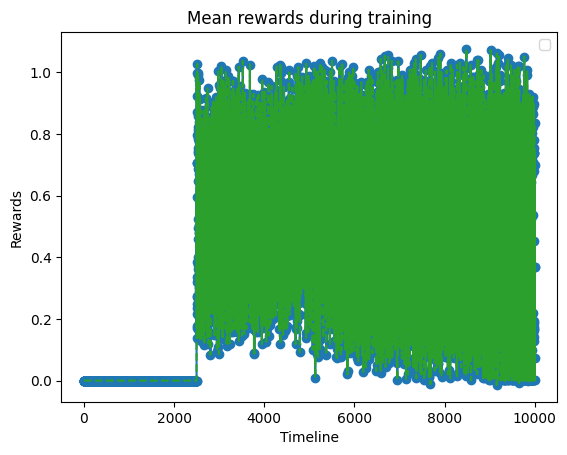

In [10]:
learn_at = 2500
epsilon = 0.87
no_episodes_train = 10000

learning_rate = 1e-5
discount_factor = 0.99

env = gym.make('highway-fast-v0', render_mode='rgb_array')
env.config['right_lane_reward'] = 0.76
env.config['lane_change_reward'] = 0.15
env.config['collision_reward'] = -0.1
env.config['reward_speed_range'] = [20, 30]
env.config['normalize_reward'] = False

model = DQN(
    discount_factor,
    learn_at,
    learning_rate,
    env.action_space.n,
    env.observation_space.shape[0],
    epsilon,
    no_episodes_train
)
out_loss = []
rewards = []

reward_in_scope = 0
out_loss_in_scope = 0
for i in range(0, no_episodes_train):
        print("EP NO: ", i)
        obs, info = env.reset()
        done = truncated = False
        cnt = 1
        while not (done or truncated):
            action = model.action_to_take(obs, env)
            obs_next, reward, done, truncated, info = env.step(action)
            if i > learn_at:
                reward_in_scope += reward
                out_loss_in_scope += model.replay(i, batch_size=256)
                model.epsilon -= 0.00001
                cnt += 1
            model.update_replay_memory([obs, action, reward, obs_next])
            # env.render()

        out_loss.append(out_loss_in_scope) # NOTE: proveriti i uprosecavanje LOSS; 
        rewards.append(reward_in_scope/cnt)
        reward_in_scope = 0
        out_loss_in_scope = 0

timeline = [i for i in range(0, len(rewards))]
plot_graph(timeline, rewards, "Timeline", "Rewards", "highway_rewards.png", "Mean rewards during training", ["Mean rewards points", "Reward trend"])

# save model
torch.save(model, "out/highway/model.pt")
print("--------------DONE TRAINING--------------")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


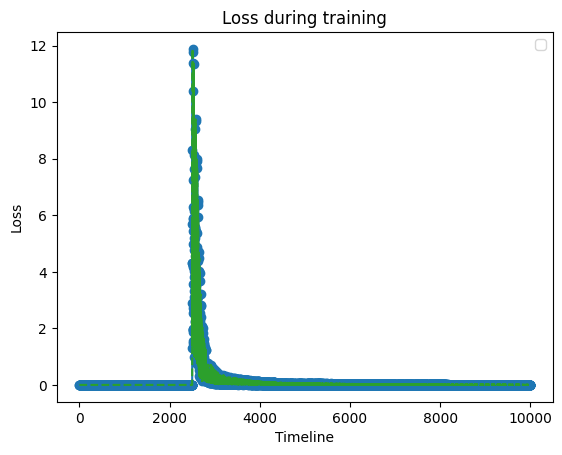

In [11]:
plot_graph(timeline, out_loss, "Timeline", "Loss", "highway_loss.png", "Loss during training", ["Loss Points", "Loss func"])

U ovom koraku se prethodno trenirani model ucitava i pusta u rad na 1000 epizoda. Na osnovu tih epizoda se prikupljaju nagrade i prikazaju na graficima (loss i rewards). Pre toga se konfigurise okruzenje, gde se dodeljuju specificne vrednosti nagrada dobijene eksperimentalnim putem.

In [9]:
model = torch.load("out/highway/model.pt")

rewards_avg = []
rewards = []
eps = []
ep_cnt_ = 0
for i in range(500):
  done = truncated = False
  obs, info = env.reset()
  cnt = 1
  reward_ = 0
  ep_cnt_ += 1
  # print(ep_cnt_)
  eps.append(ep_cnt_)
  while not (done or truncated):
    action = model.action_to_take(obs, env)
    obs, reward, done, truncated, info = env.step(action)
    reward_ += reward
    cnt += 1
    # env.render()
  rewards.append(reward_)
  rewards_avg.append(reward_/cnt)
plot_graph(moving_average(rewards, 50), "eps", "rewards", "model test", "Test", 0)
plot_graph(moving_average(rewards_avg, 50), "eps", "rewards", "model test", "Test", 1)

AttributeError: 'NoneType' object has no attribute 'get_image'

Dodatna validacija uz pomoc stablebaseline modula i njihove implementacije DQN algoritma.

In [ ]:
from stable_baselines3 import DQN
env_2 = gym.make('highway-fast-v0', render_mode='rgb_array')
model = DQN('MlpPolicy', env_2,
              policy_kwargs=dict(net_arch=[256, 256]),
              learning_rate=5e-4,
              buffer_size=15000,
              learning_starts=3000,
              batch_size=128,
              gamma=0.99,
              train_freq=1,
              gradient_steps=1,
              target_update_interval=50,
              verbose=1,
              tensorboard_log="highway_dqn/",
              exploration_initial_eps = 0.9,
              exploration_final_eps = 0.65
            )

model.learn(10000, progress_bar=True)
model.save("highway_dqn/model")

In [ ]:
model.load("highway_dqn/model")
rewards_off_the_shelf = []
for i in range(500):
    done = truncated = False
    obs, info = env.reset()
    rewards_in_scope = 0
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        _, rewards, done, truncated, _ = env.step(action)
        rewards_in_scope += rewards
        env.render()
    print(i)
    rewards_off_the_shelf.append(rewards_in_scope)

plot_graph(moving_average(rewards_off_the_shelf, 50), "Episodes", "Moving average", None, "Off the shelf rewards", None)